# Lab 3 - N Puzzle

Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

Description for N=15 : [`https://en.wikipedia.org/wiki/15_puzzle`](https://en.wikipedia.org/wiki/15_puzzle)

## Importing library

In [31]:
from collections import deque
import os
from typing import Deque, TypeVar

import random

from IPython.display import Image, Markdown, display


import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt
import matplotlib.animation as animation


import joblib
from joblib import Parallel, delayed

In [32]:
# Default initial and goal states for debugging -> It should take 2 moves to solve
DEFAULT_INITIAL_STATE: NDArray = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [0, 7, 8],
    ]
)

DEFAULT_GOAL_STATE: NDArray = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 0],
    ]
)

## Utility

### Look at the frontier and take a maximum of 4 neighbors 

> In the edge the number of neighbors is 3<br>
> In the corner the number of neighbors is 2

In [33]:
def get_neighbors(state: NDArray[np.int32]) -> list[NDArray[np.int32]]:
    neighbors: list[NDArray[np.int32]] = []
    x, y = np.argwhere(state == 0)[0]
    moves: list[tuple[int, int]] = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    for dx, dy in moves:
        nx, ny = x + dx, y + dy
        if 0 <= nx < state.shape[0] and 0 <= ny < state.shape[1]:
            new_state: NDArray[np.int32] = state.copy()
            new_state[x, y], new_state[nx, ny] = new_state[nx, ny], new_state[x, y]
            neighbors.append(new_state)
    return neighbors

### Creating the goal state

This function lets also decide where the empty cell is located using $(x, y)$ coordinate for the matrix

Use case:
> Empty cell in the top left instead of the bottom right <br>
> Empty cell in the center 

The remaining cell will assume ordered integer value left to right, top to bottom in the range $[1, N^2)$

I saw that some problem require the solution to be in a spiral, but I lazily thought that you could just create it yourself and use that as the `goal_state`

In [34]:
def generate_goal_state(dim: int, null_position: tuple[int, int] | None = None) -> NDArray[np.int32]:
    """
    Generates a goal state for
    an NxN puzzle with the null
    position at the specified position
    """
    if null_position is None:
        # If the null position is not specified, set it to the bottom right corner
        null_position = (dim - 1, dim - 1)

    goal_state = np.zeros((dim, dim), dtype=np.int32)
    num = 1
    for i in range(dim):
        for j in range(dim):
            if (i, j) == null_position:
                continue
            goal_state[i, j] = num
            num += 1
    return goal_state

### Generate the Starting State

Starting from the goal state, make a random number of **legal** moves to always have a valid problem to solve

Keith Conrad proved that some configuration of the 15-Puzzle (and rubik's cube) cannot be solved: [`https://kconrad.math.uconn.edu/blurbs/grouptheory/15puzzle.pdf`](https://kconrad.math.uconn.edu/blurbs/grouptheory/15puzzle.pdf)

So to avoid this situation, making only legal moves to create the starting position will always result in a solvable problem and thus limiting the possible error to the algorithm implementation

In [35]:
def scramble_state(goal_state: NDArray[np.int32], moves: int = 10) -> NDArray[np.int32]:
    """
    Creates a solvable initial state by applying a number of random moves to the goal state.
    """
    state: NDArray[np.int32] = goal_state.copy()
    previous_state: NDArray[np.int32] | None = None

    for _ in range(moves):
        # Get all possible moves
        neighbors: list[NDArray[np.int32]] = get_neighbors(state)
        # Avoid undoing the previous move
        if previous_state is not None:
            neighbors = [neighbor for neighbor in neighbors if not np.array_equal(neighbor, previous_state)]
        # Randomly choose one of the next moves
        next_state: NDArray[np.int32] = random.choice(neighbors)
        previous_state = state
        state: NDArray[np.int32] = next_state
    return state

### Display Numpy Array as Latex Matrix

Small utility to display in the notebook a nice latex matrix associated with the numpy array (2D) used for the problem

In [36]:
def display_array_as_latex(arr: np.ndarray, title: str | None = None) -> None:
    """Displays a NumPy array as a LaTeX matrix in Markdown."""
    # Start matrix environment
    latex = r"\begin{bmatrix}"

    # Add rows
    for i, row in enumerate(arr):
        latex += r" \\ ".join([" & ".join(str(x) if x != 0 else r"\square" for x in row)])
        if i < len(arr) - 1:
            latex += r" \\ "

    # Close matrix environment
    latex += r"\end{bmatrix}"

    # Add title if provided
    if title:
        latex = f"### {title}\n\n${latex}$"
    else:
        latex = f"${latex}$"

    display(Markdown(latex))

## Breadth-First Search

To speedup computation and reduce memory impact there are two important element:

* visited set: Is a set the use the bytes of the array that are hashable and reducing the lookup time to $O(1)$
* parents: Avoid storing entire path during the search but just the direct parent for each solution. Then reconstruct the path given the solution from the parent

In [37]:
class OLD_BFS:
    def __init__(
        self,
        initial_state: NDArray[np.int32],
        goal_state: NDArray[np.int32],
        log_interval: int = 0,
    ) -> None:

        self.initial_state = initial_state
        self.goal_state = goal_state
        self.visited: set[bytes] = set()
        self.parents: dict[bytes, bytes] = {}
        self.queue: Deque[NDArray[np.int32]] = deque()
        self.cost: int = 0
        self.log_interval: int = log_interval
        self.results: dict[str, list[NDArray[np.int32]] | int | bool] = {"valid": False}

    def solve(self) -> dict[str, list[NDArray[np.int32]] | int | bool]:
        self.queue.append(self.initial_state)
        self.visited.add(self.initial_state.tobytes())
        self.cost = 0

        while self.queue:
            current_state: NDArray[np.int32] = self.queue.popleft()
            if np.array_equal(current_state, self.goal_state):
                path: list[NDArray[np.int32]] = self.reconstruct_path(current_state)
                self.results = {"path": path, "length": len(path), "cost": self.cost, "valid": True}
                return self.results
            self.cost += 1
            for neighbor in get_neighbors(current_state):
                neighbor_key = neighbor.tobytes()
                if neighbor_key not in self.visited:
                    self.visited.add(neighbor_key)
                    self.parents[neighbor_key] = current_state.tobytes()
                    self.queue.append(neighbor)

            if self.log_interval and self.cost % self.log_interval == 0:
                print(f"Step: {self.cost}")

        print("BFS: No solution found")
        return self.results

    def reconstruct_path(self, state: NDArray[np.int32]) -> list[NDArray[np.int32]]:
        path = [state]
        state_key = state.tobytes()
        while state_key in self.parents:
            parent_key = self.parents[state_key]
            parent_state = np.frombuffer(parent_key, dtype=state.dtype).reshape(state.shape)
            path.append(parent_state)
            state_key = parent_key
        path.reverse()
        return path

In [38]:
class BFS:
    def __init__(
        self,
        initial_state: NDArray[np.int32],
        goal_state: NDArray[np.int32],
        log_interval: int = 0,
    ) -> None:
        self.initial_state: NDArray[np.int32] = initial_state
        self.goal_state = goal_state

        self.visited: set[bytes] = set()
        self.frontier: Deque[NDArray[np.int32]] = deque()
        self.parents: dict[bytes, bytes] = {}
        self.queue: Deque[NDArray[np.int32]] = deque()
        self.total_expanded_nodes: int = 0
        self.steps: int = 0
        self.log_interval: int = log_interval
        self.results: dict[str, list[NDArray[np.int32]] | int | bool] = {"valid": False}

    def solve(self, n_jobs: int = 1) -> dict[str, list[NDArray[np.int32]] | int | bool]:
        '''Solves the puzzle using BFS and returns the results.
        ## Parameters
        n_jobs : int, optional (default=1) (range [-1, joblib.cpu_count()])
            The number of jobs to run in parallel.
            If -1, all CPUs are used.
            If 1 is given, no parallel computing code is used at all,

        ## Returns
        results : dict
            A dictionary containing the following keys:
            cost : int
                The total number of expanded nodes.
            quality : int
                The quality of the solution (i.e. the number of node use in the solution).
            path : list[NDArray[np.int32]]
                A list of states representing the solution.
            valid : bool
                Whether the solution is valid or not.
        '''

        if n_jobs < -1 and n_jobs != 0 and n_jobs > joblib.cpu_count():
            raise ValueError(
                "n_jobs should be in the range [-1 (automatically use all your cores), joblib.cpu_count()] and != 0"
            )
        n_jobs = joblib.cpu_count() if n_jobs == -1 else n_jobs

        if n_jobs == 1:
            return self.serial_solve()
        return self.parallel_solve(n_jobs)

    def serial_solve(self) -> dict[str, list[NDArray[np.int32]] | int | bool]:
        self.queue.append(self.initial_state)
        self.visited.add(self.initial_state.tobytes())

        while self.queue:
            current_state: NDArray[np.int32] = self.queue.popleft()
            if np.array_equal(current_state, self.goal_state):
                path: list[NDArray[np.int32]] = self.reconstruct_path(current_state)
                self.results = {"path": path, "length": len(path), "cost": len(self.visited), "valid": True}
                return self.results

            for neighbor in get_neighbors(current_state):
                neighbor_key = neighbor.tobytes()
                if neighbor_key not in self.visited:
                    self.visited.add(neighbor_key)
                    self.parents[neighbor_key] = current_state.tobytes()
                    self.queue.append(neighbor)

            if self.log_interval and len(self.visited) % self.log_interval == 0:
                print(f"Step: {len(self.reconstruct_path(current_state))}")

        print("BFS: No solution found")
        return self.results

    def parallel_solve(self, n_jobs: int) -> dict[str, list[NDArray[np.int32]] | int | bool]:
        self.frontier.append(self.initial_state)
        self.visited.add(self.state_to_key(self.initial_state))
        self.steps = 0

        while self.frontier:
            current_level_size: int = len(self.frontier)
            current_level_states: list[NDArray[np.int32]] = [self.frontier.popleft() for _ in range(current_level_size)]

            self.total_expanded_nodes += current_level_size
            # Expand nodes at the current level in parallel
            results = Parallel(n_jobs=n_jobs)(delayed(self.expand_node)(state) for state in current_level_states)

            # Collect successors and update visited and frontier
            for successors in results:
                if successors is None:
                    continue
                for neighbor_key, neighbor_state, parent_key in successors:
                    if neighbor_key not in self.visited:
                        self.visited.add(neighbor_key)
                        self.parents[neighbor_key] = parent_key
                        # Check if goal state is found
                        if np.array_equal(neighbor_state, self.goal_state):
                            print("Solution found!")
                            path: list[NDArray[np.int32]] = self.reconstruct_path(neighbor_state)
                            self.results = {
                                "path": path,
                                "length": len(path),
                                "cost": self.total_expanded_nodes,
                                "valid": True,
                            }
                            return self.results

                        self.frontier.append(neighbor_state)

            if self.log_interval:
                self.steps += 1
                if self.steps % self.log_interval == 0:
                    print(
                        f"Step: {self.steps}, Expanded nodes: {self.total_expanded_nodes}, Frontier size: {len(self.frontier)}"
                    )

        print("No solution found")
        return self.results

    def expand_node(self, state: NDArray[np.int32]) -> list[tuple[bytes, NDArray[np.int32], bytes]]:
        state_key: bytes = self.state_to_key(state)
        successors: list[tuple[bytes, np.ndarray, bytes]] = []
        neighbors: list[NDArray[np.int32]] = get_neighbors(state)
        for neighbor in neighbors:
            neighbor_key: bytes = self.state_to_key(neighbor)
            successors.append((neighbor_key, neighbor, state_key))
        return successors

    def reconstruct_path(self, state: NDArray[np.int32]) -> list[NDArray[np.int32]]:
        path: list[NDArray[np.int32]] = [state]
        state_key: bytes = self.state_to_key(state)
        while state_key in self.parents:
            parent_key: bytes = self.parents[state_key]
            parent_state: NDArray[np.int32] = self.key_to_state(parent_key, state.shape, state.dtype)
            path.append(parent_state)
            state_key: bytes = parent_key
        path.reverse()
        return path

    @staticmethod
    def state_to_key(state: NDArray[np.int32]) -> bytes:
        return state.tobytes()

    T = TypeVar("T", bound=np.generic)

    @staticmethod
    def key_to_state(key: bytes, shape: tuple[int, int], dtype: np.dtype[T]) -> NDArray[T]:
        return np.frombuffer(key, dtype=dtype).reshape(shape)

## Visual Utility

I always liked visualizing the output of an algorithm, especially if it solves a problem I have a lot of trouble to understand the moves and predict the best moves

P.S.

This function requires only a path that is the list of matrices each one of them representing a state in order from start to finish.

This function also allow to edit the name of the gif and possibly adding the name of an additional algorithm. Feel free to use it if you have the same structure to visualize your work!

In [39]:
def save_solution_gif(
    path: list[NDArray[np.int32]],
    *,
    gif_name: str = "",
    algorithm_name: str | None = None,
    fps: int = 2,
) -> None:
    """
    Saves an animation of the N-puzzle solution path as a GIF.

    Args:
        path (list of np.ndarray): List of puzzle states representing the solution path.
    """

    N = path[0].shape[0]
    # Add .gif extension if not present
    if not gif_name.endswith(".gif"):
        gif_name += ".gif"

    # Add to the name the dimension of the grid (e.g. solution.gif -> solution_3x3.gif)
    gif_name = gif_name.replace(".gif", f"{N}x{N}.gif")

    if algorithm_name is not None:
        gif_name = f"{algorithm_name}_{gif_name}"

    video_dir = "gifs"
    os.makedirs(video_dir, exist_ok=True)
    gif_output_path: str = os.path.join(video_dir, gif_name)
    fig, ax = plt.subplots(figsize=(N, N))
    ax.axis("off")

    # Initialize the image with the first state
    img = ax.imshow(path[0], cmap="tab20", vmin=0, vmax=N * N - 1)

    # Initialize texts for each cell
    texts = []
    for (i, j), val in np.ndenumerate(path[0]):
        text = ax.text(j, i, str(val) if val != 0 else "", va="center", ha="center", fontsize=16, color="white")
        texts.append(text)

    # Update function for animation
    def update(frame):
        state = path[frame]
        # Update the image data
        img.set_data(state)
        # Update text in each cell
        for k, (_, val) in enumerate(np.ndenumerate(state)):
            texts[k].set_text(str(val) if val != 0 else "")
        ax.set_title(f"Step {frame}", fontsize=16)
        return [img] + texts

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=range(len(path)), blit=True, interval=500, repeat=False)

    # Save the animation as a GIF
    ani.save(gif_output_path, writer="pillow", fps=fps)
    plt.close(fig)
    print(f"Gif saved in `{gif_output_path}`")
    display(Image(filename=gif_output_path))

# Running the Searches

There are 2 ways to add complexity to the problem:
1. Increasing the dimension of the matrix
2. Increasing the number of random initial moves 

### Initial State (4x4)

$\begin{bmatrix}1 & 2 & 4 & 7 \\ 5 & 6 & 3 & 8 \\ 9 & 14 & \square & 11 \\ 13 & 15 & 10 & 12\end{bmatrix}$

### Solution Grid (moves=20)

$\begin{bmatrix}1 & 2 & 3 & 4 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 11 & 12 \\ 13 & 14 & 15 & \square\end{bmatrix}$

---

| Dimension               | Quality   | Cost   |
|-------------------------|-----------|--------|
| 4x4 | 13 | 34728 |

Gif saved in `gifs\4x4.gif`


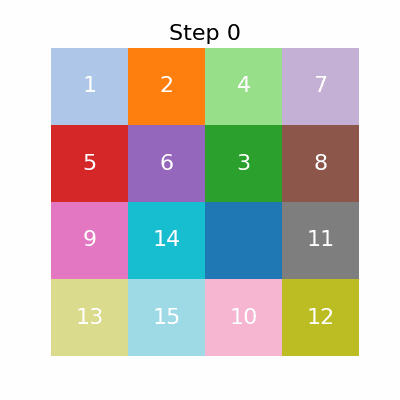

In [ ]:
dimension = 4
# The max number of moves required to solve the puzzle, so scramble the grid with this number of moves
# to a fairly random starting point
# https://puzzling.stackexchange.com/a/5477
moves = dimension * dimension * (dimension - 1)
moves = 20


# Generate a NxN solution grid in order from 0 to dimension^2 - 1
goal_state: NDArray[np.int32] = generate_goal_state(dimension)

# Generate a NxN grid of random numbers from 0 to dimension^2 - 1
initial_state: NDArray[np.int32] = scramble_state(goal_state, moves)

display_array_as_latex(goal_state, title=f"Solution Grid ({dimension}x{dimension})")
display_array_as_latex(initial_state, title=f"Initial State ({moves=})")

display(Markdown("---"))

# Solve using Breadth First Search
bfs_solver = BFS(initial_state, goal_state)

result = bfs_solver.solve()

if result.get("valid"):
    path, quality, cost = result.get("path"), result.get("length"), result.get("cost")

    display(
        Markdown(
            f"| Dimension               | Quality   | Cost   |\n|-------------------------|-----------|--------|\n| {dimension}x{dimension} | {quality} | {cost} |"
        )
    )
    if isinstance(path, list):
        save_solution_gif(path)